In [28]:
import pandas as pd
from datetime import datetime
import yfinance
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries


def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    file_name=quote+".csv"
    df.to_csv(file_name)
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        file_name = quote + ".csv"
        df.to_csv(file_name, index=False)
    return file_name

In [29]:
nm = input()
print(nm)
file = get_historical(nm)
# df=pd.read_csv(file)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(5,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

[*********************100%%**********************]  1 of 1 completed


In [31]:
data.describe()


,Open,High,Low,Close,Adj Close,Volume
count,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02
mean,124.852381,126.633633,123.082579,124.919545,124.919545,6.410433e+07
std,23.367233,23.392651,23.393606,23.436673,23.436673,2.723822e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,2.237840e+07
25%,104.190002,106.134998,102.519997,104.470003,104.470003,4.737212e+07
50%,125.279999,127.365002,124.000000,125.854248,125.854248,5.675740e+07
75%,141.255005,143.377502,139.819996,142.023251,142.023251,7.226162e+07
max,177.529999,180.139999,177.490005,178.220001,178.220001,2.726620e+08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


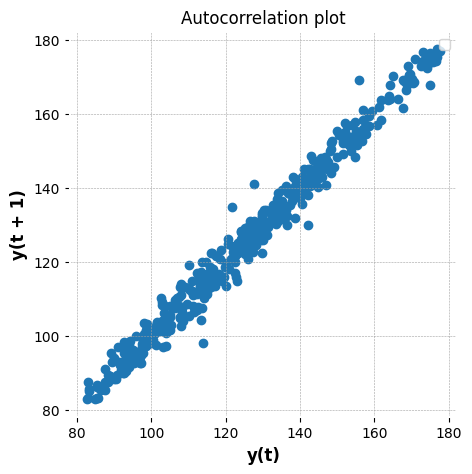

In [32]:
import pandas as pd
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(data['Open'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend()


values = pd.DataFrame(data['Open'].values)
dataframe = pd.concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
# print(result)

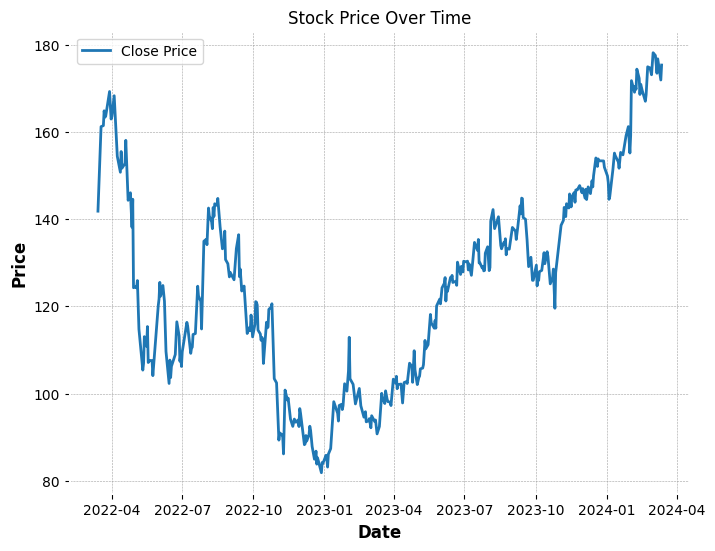

In [33]:
plt.figure(figsize=(8,6))
plt.plot(data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.show()

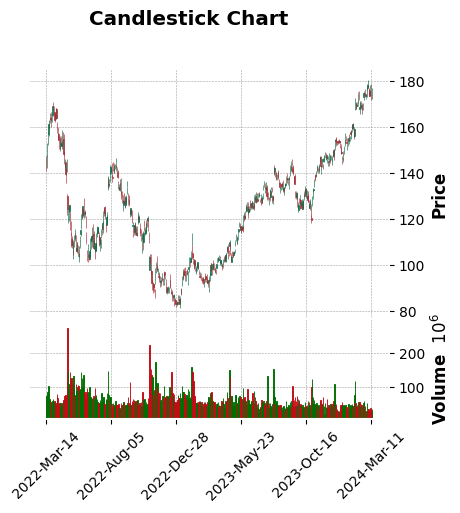

In [34]:
import mplfinance as mpf
mpf.plot(data, type='candle',
        style='charles',
        title='Candlestick Chart',
        volume=True, figsize=(5,5)
        )

In [35]:
#splitting the data into 70% training and 30% testing
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
# plt.figure(figsize=(5,5))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Open Prices')
# plt.plot(data['Open'], 'green', label='Train data')
# plt.plot(test_data['Open'], 'blue', label='Test data')
# plt.legend()

In [36]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# preprocessing training data
train = train_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
# from numpy.random import seed 
# seed(2019)

In [37]:
#preprocessing testing data
test = test_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
test_scaled = scaler.fit_transform(test)
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) 
    y_test.append(test_scaled[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [38]:
# the CNN model
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

In [39]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
14/14 [==============================] - 2s 6ms/step - loss: 0.0256 - acc: 0.0045
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0134 - acc: 0.0045
Epoch 3/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0105 - acc: 0.0045
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0095 - acc: 0.0045
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0081 - acc: 0.0045
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0074 - acc: 0.0045
Epoch 7/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0077 - acc: 0.0045
Epoch 8/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0066 - acc: 0.0045
Epoch 9/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0075 - acc: 0.0045
Epoch 10/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0068 - acc: 0.0045
Epoch 11/50
14/14 [==============================] - 0s 6ms/step - lo

2/2 [==============================] - 0s 6ms/step
predicted stock price for tomorrow:  [170.47717]


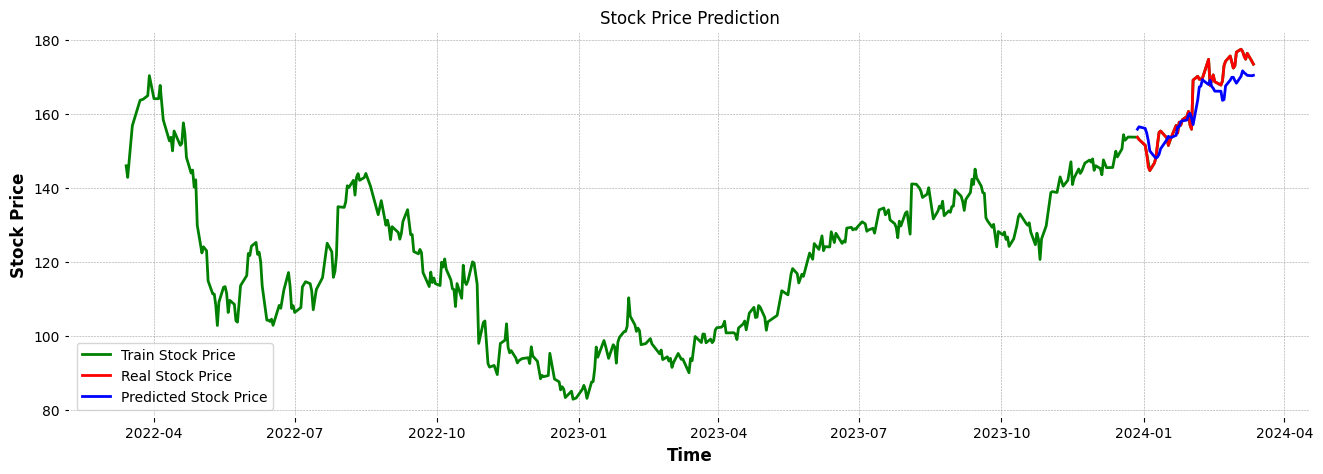

In [40]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print("predicted stock price for tomorrow: ",predicted_stock_price[len(predicted_stock_price)-1])

plt.figure(figsize=(16,5))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mse15 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse15))
mae15 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae15))
rmse15 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse15))
r215 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r215))

MSE: 20.07849061844286
MAE: 3.6671549479166665
RMSE: 4.480902879827107
R2 Score: 0.8029648809707495
